Notebook with EDA, data preparation and augmentation, building and model training

# Table Of Contents
- [Downaloding data from Kaggle](#downloading-data-from-kaggle)
- [Exploring dataset](#exporing-dataset)
- [Prepare data](#prepare-data)
- [Short EDA](#short-eda)
- [Data preprocessing](#data-preprocessing)


# Downloading data from Kaggle
During exploratory data analysis we will work with data from Kaggle competition <a href="https://www.kaggle.com/competitions/airbus-ship-detection">AirBus Ship Detection Challenge</a>. To run cells with code from Google Colab or Jupyter Notebook we need to load data using Kaggle API.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Next you need to upload your kaggle.json (situated in profile settings)

In [ ]:
from google.colab import files
files.upload()

All files and additional data can be stored in your google drive to increase speed of running code cells 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download dataset from kaggle 

In [3]:
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [05:40<00:00, 58.5MB/s]
100% 28.6G/28.6G [05:40<00:00, 90.1MB/s]


Next we need to save data to working directory. You can do it in 2 ways - locally in google colab/jupyter notebook or in your Google Drive (create empty <i>AirBusDataset</i> directory in advance)
<br><b>Google Colab</b></br>

In [4]:
!mkdir /content/AirBusDataset
!cp /content/airbus-ship-detection.zip /content/AirBusDataset/airbus-ship-detection.zip
!unzip -q /content/AirBusDataset/airbus-ship-detection.zip -d /content/AirBusDataset/
!rm /content/AirBusDataset/airbus-ship-detection.zip

cp: error writing '/content/AirBusDataset/airbus-ship-detection.zip': No space left on device
[/content/AirBusDataset/airbus-ship-detection.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/AirBusDataset/airbus-ship-detection.zip or
        /content/AirBusDataset/airbus-ship-detection.zip.zip, and cannot find /content/AirBusDataset/airbus-ship-detection.zip.ZIP, period.


<b>Google Drive</b>

In [ ]:
!mkdir /content/gdrive/MyDrive/AirBusDataset
!cp /content/airbus-ship-detection.zip /content/gdrive/MyDrive/AirBusDataset/airbus-ship-detection.zip
!unzip -q /content/gdrive/MyDrive/AirBusDataset/airbus-ship-detection.zip -d /content/gdrive/MyDrive/AirBusDataset/
!rm /content/gdrive/MyDrive/AirBusDataset/airbus-ship-detection.zip

<br>Import all nessary tools and libs for further analysis and model training</br>

In [ ]:
import numpy as np
import pandas as pd 
import altair as alt
import os
import torch
import random
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from keras.preprocessing.image import ImageDataGenerator
from scipy import ndimage
from PIL import Image

# Exploring dataset
<br>
Determine the size of the original dataset
</br>

In [ ]:
print("Amount of train images - ", len([name for name in os.listdir('/content/AirBusDataset/train_v2')]))
print("Amount of test images - ", len([name for name in os.listdir('/content/AirBusDataset/test_v2')]))

Amount of train images -  192556
Amount of test images -  15606


Next let's plot example of train image

(768, 768)


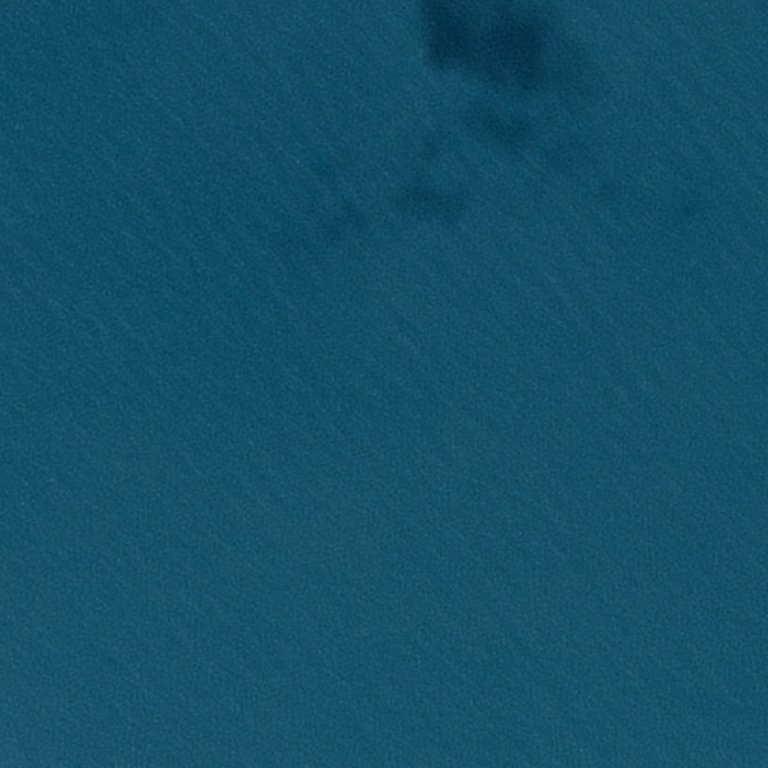

In [ ]:
img_zero_ships = Image.open('/content/AirBusDataset/train_v2/0008d6216.jpg')
print(img_zero_ships.size)
img_zero_ships

(768, 768)


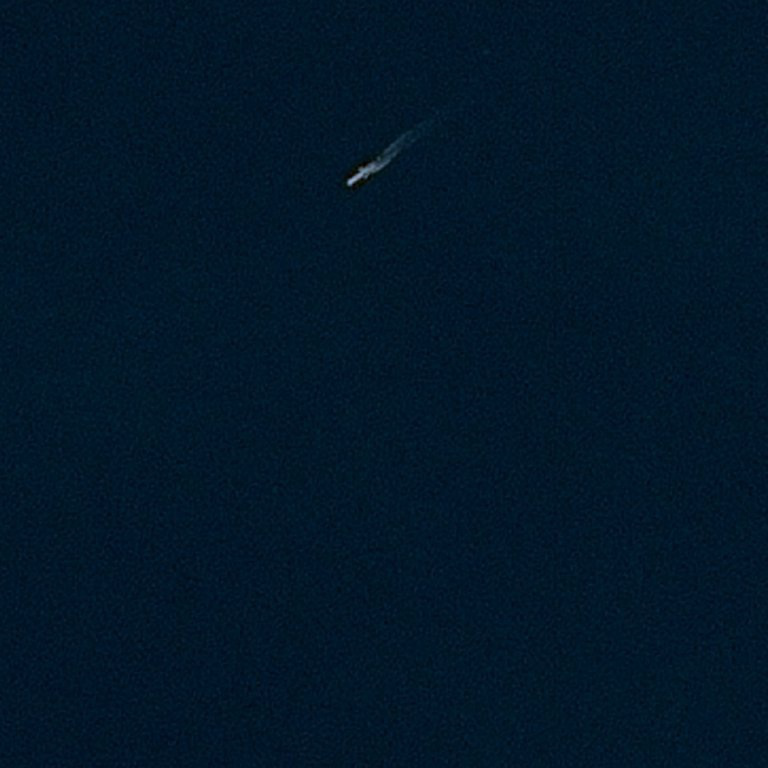

In [ ]:
img_ships = Image.open('/content/AirBusDataset/train_v2/0005d6d95.jpg')
print(img_ships.size)
img_ships

Open ground truth for the training images

In [ ]:
image_masks = pd.read_csv('/content/AirBusDataset/train_ship_segmentations_v2.csv')  
image_masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
print("Length of image_masks dataframe is ", len(image_masks))
print("Amount of unique images in image_masks is ", len(image_masks["ImageId"].unique()))

Length of image_masks dataframe is  231723
Amount of unique images in image_masks is  192556


In [ ]:
print("Amount of images with empty mask (without detected ships)", len(image_masks[image_masks['EncodedPixels'].isna()]))

Amount of images with empty mask (without detected ships) 150000


We should visualize image and mask. Mask was represented as string with encoded pixels (RLE format). RLE is run-length encoding. It is used to encode the location of foreground objects in segmentation.  That's why we need to decode rle to mask. [1]

In [ ]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle: str, shape=(768, 768)):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  

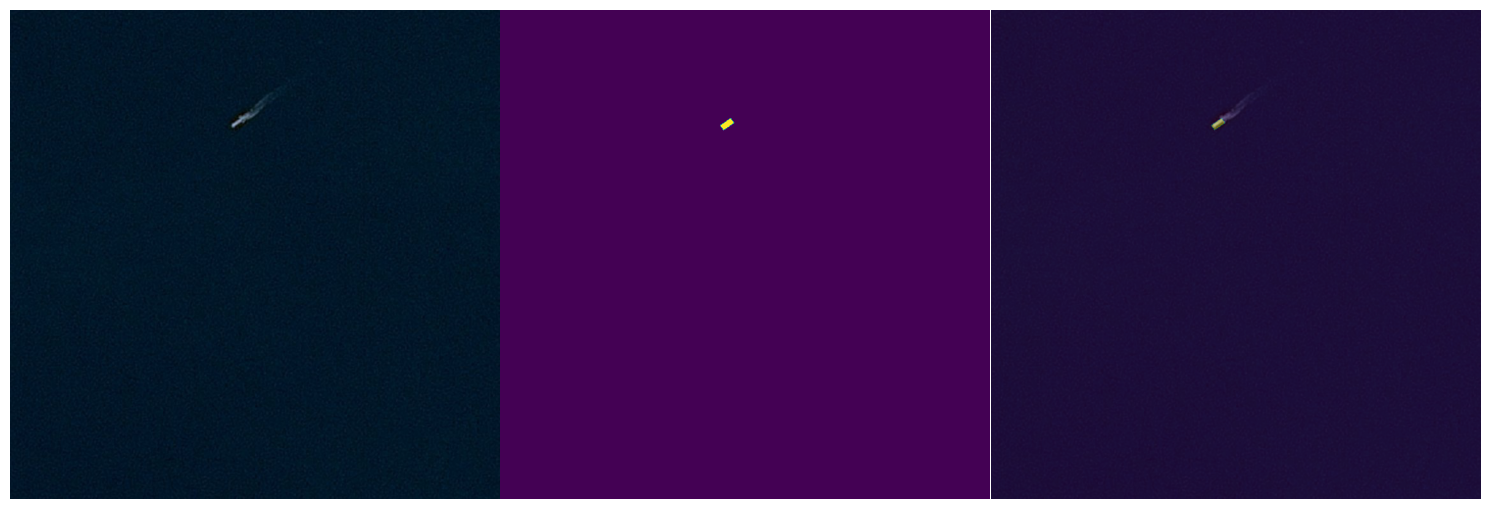

In [ ]:
img = Image.open('/content/gdrive/MyDrive/AirBusDataset/train_v2/0005d6d95.jpg')
img_masks = image_masks.loc[image_masks['ImageId'] == '0005d6d95.jpg', 'EncodedPixels'].tolist()

# take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle2mask(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

# Prepare data
<br>
First of all, let's create configuration class that saves all necessary parameters for data preprocessing and model training.
</br>

In [ ]:
class Config:
    # directory with train data saved in my google drive (unavailable now)
    data_dir = '/content/AirBusDataset/train_v2/'
    mask_dir = '/content/AirBusDataset/masks/'
    augmented_dir = '/content/AirBusDataset/train_v2/'
    aug_masks_dir = '/content/AirBusDataset/masks/'
    logdir = '/content/logdir'

    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32

    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1

    seed = 42
    lr = 0.01
    epochs = 50
    device = tf.device('/device:GPU:0') if tf.config.list_physical_devices('GPU') else tf.device('/CPU:0')

Next we should set the same random seed

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(Config.seed)  

Now we can create joined dataframe with 3 features - image id, amount of ships and sum of the areas of the detected ships in the image. (N.B. next cell needs a long time for running)

Also we will check image size during iteration though all samples.

In [ ]:
img_ids = []
ships = []
sizes = []
squares = []

for index, row in image_masks.iterrows():
    image_id = row['ImageId']

    if image_id not in img_ids:
        img = Image.open(Config.data_dir + image_id)
        sizes.append(img.size)
        img_ids.append(image_id)
        img_masks = image_masks.loc[image_masks['ImageId'] == image_id, 'EncodedPixels'].tolist()
        # if no ships on image
        if type(img_masks[0]) is not str and np.isnan(img_masks[0]):
            ships.append(0)
            squares.append(0)
        else:     
            ships.append(len(img_masks))
            full_mask = np.zeros((768, 768))
            for mask in img_masks:
                full_mask += rle2mask(mask)
            lbl = label(full_mask) 
            props = regionprops(lbl)
            square_sum = 0
            for prop in props:
              square_sum += (np.abs(prop.bbox[2] - prop.bbox[0]) * np.abs(prop.bbox[3] - prop.bbox[1]))
            squares.append(square_sum)

In [ ]:
joined_data = {'ImageId': img_ids, 'AmountOfShips': ships, 'SquareOfDetected': squares}
ships_dfrm = pd.DataFrame.from_dict(joined_data)
ships_dfrm.head(10)

,ImageId,AmountOfShips,SquareOfDetected
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,1,3744
3,000194a2d.jpg,5,1909
4,0001b1832.jpg,0,0
5,00021ddc3.jpg,9,2433
6,0002756f7.jpg,2,837
7,0002d0f32.jpg,0,0
8,000303d4d.jpg,0,0
9,00031f145.jpg,1,841


Check unique values of image size

In [ ]:
sizes = np.array(sizes)
print("Unqiue shapes of images: ", np.unique(sizes))

Unqiue shapes of images:  [768]


All images are the same shape (768, 768)

In [ ]:
len(ships_dfrm)

192556

Since I spent a lot of time testing, I had to return to this dataframe again and again, therefore, in order not to waste time each time processing, I loaded it from a csv file.

In [ ]:
# ships_dfrm.to_csv('ships_dfrm.csv', index=False)

In [ ]:
# ships_dfrm = pd.read_csv('/content/ships_dfrm.csv') 
# ships_dfrm.head()

# Short EDA
<br>We shoud understand how many images with detected ships we have in initial dataset</br>

In [ ]:
ships_count = pd.DataFrame()
ships_count["ships"] = ships_dfrm['AmountOfShips'].value_counts().index
ships_count["count"] = ships_dfrm['AmountOfShips'].value_counts().values
alt.Chart(ships_count).mark_arc().encode(
    theta="count",
    color=alt.Color("ships", scale=alt.Scale(scheme='tableau20'))
)

alt.Chart(...)

In [ ]:
non_zero_ships_count = ships_count[ships_count['ships'] != 0]
alt.Chart(non_zero_ships_count).mark_bar().encode(
    x = "ships",
    y="count",
    color=alt.Color("ships", scale=alt.Scale(scheme='category20c'))
)

alt.Chart(...)

As we can see, initial dataset imbalanced. That's why I decided to use augmentation techniques to increase samples where ships were detected.
<br></br>
Next let's analysize distribution of the sum of squares of detected ships <i> (the possible max value is 768 x 768 = 589824 ) </i>

In [ ]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [ ]:
square_count = pd.DataFrame()
temp = ships_dfrm[ships_dfrm['SquareOfDetected'] != 0]
square_count["square"] = temp['SquareOfDetected'].value_counts().index
square_count["count"] = temp['SquareOfDetected'].value_counts().values
alt.Chart(square_count).mark_bar().encode(
    x = "square",
    y="count",
    color=alt.Color("square", scale=alt.Scale(scheme='category20c'))
)

alt.Chart(...)

In [ ]:
square_count.sort_values(by=['count'], ascending=False)

,square,count
0,240,178
1,156,168
2,110,166
3,180,163
4,144,142
...,...,...
6699,31157,1
6700,21536,1
6701,53025,1
6702,33863,1


As we see, most often, among the images, the area of the identified boats is very small. This complicates the task of segmentation.

<b>Some clear conslusions from the most short EDA in the world :) </b>
<ul>
<li>There are over 25 000 samples with only one detected ship and over 7000 samples with two ships. </li>
<li>The maximum amount of detected ships on samples is 15.</li>
<li>Initial dataset so imbalanced. For better model training we need oversample dataset with images of detected ships. </li>
</ul>

# Data preprocessing


## Create and save full masks


In [ ]:
!mkdir /content/AirBusDataset/masks

In [ ]:
def save_masks(non_zeros_ships):
  for id in non_zeros_ships:
    img_masks = image_masks.loc[image_masks['ImageId'] == id, 'EncodedPixels'].tolist()
    # take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
      all_masks += rle2mask(mask)
    mask = Image.fromarray(all_masks)  
    mask = mask.convert('L')  
    mask.save(Config.mask_dir + "/" + id[:-4] + ".png")

In [ ]:
non_zero_ships_data = ships_dfrm[ships_dfrm['AmountOfShips'] != 0]
non_zeros_ships = list(non_zero_ships_data['ImageId'].unique()) 
save_masks(non_zeros_ships)

## Data augmentation
We need to increase our dataset, that's why next lines of code were written for transformations of samples with detected ships and creating new ones.

In [ ]:
class AugmentationData:
    """
    Class for data augmentation. Some methods of transformation
    will applied to exsiting images with detected ships. After that new samples
    will be saved in train directory.

        Attributes
        ----------
        train_dir: str - directory with train images
        mask_dir: str - directory with train masks
        output_dir: str - directory with output augmented images
        new_mask_dir: str - directory with output changed masks
        non_zero_ships: list - list of images id with detected ships
        image_masks: pd.DataFrame - dataframe with masks in rle-format

        Methods
        ----------
        __init__():
          initialize paths, dataframe and list for further processing

        augmentate():
          public method for creating new images and masks
          returns list of new images/masks id
    """


    def __init__(self, non_zero_ships: list, image_masks: pd.DataFrame):
        # set random seed for reproducibility
        set_seed(42)

        # define data directories
        self.train_dir = Config.data_dir
        self.mask_dir = Config.mask_dir
        self.output_dir = Config.augmented_dir
        self.new_mask_dir = Config.mask_dir
        self.non_zero_ships = non_zero_ships
        self.image_masks = image_masks
  
    def augmentate(self) -> list:
        # create empty list for new images_id
        new_images_ids = []
        for image_id in self.non_zero_ships:
          mask_id = image_id[:-4] + ".png"
        
          # Load image, mask from file
          image = tf.io.read_file(self.train_dir + image_id)
          mask = tf.io.read_file(self.mask_dir + mask_id)

          # Decode JPEG image to tensor
          image = tf.image.decode_jpeg(image, channels=3)
          mask = tf.image.decode_png(mask, channels=1)

          # Resize image
          resized_image = tf.image.resize(image, [768, 768])
          resized_mask = tf.image.resize(mask, [768, 768])

          # Flip image, mask horizontally
          image = tf.image.flip_left_right(image)
          mask = tf.image.flip_left_right(mask) 

          # Flip image, mask vertically
          image = tf.image.flip_up_down(image)
          mask = tf.image.flip_up_down(mask)

          # Rotate image by 90 degrees clockwise
          image = tf.image.rot90(image, k=1)
          mask = tf.image.rot90(mask, k=1)

          # Convert tensor back to JPEG image and save to file
          image = tf.cast(image, tf.uint8)
          image = tf.image.encode_jpeg(image)
          tf.io.write_file(self.output_dir + image_id[:-4] + '_aug.jpg', image)

          mask = tf.image.encode_png(mask)
          tf.io.write_file(self.new_mask_dir + image_id[:-4] + '_aug.png', mask)
          new_images_ids.append(image_id[:-4] + '_aug.jpg')
        return new_images_ids

In [ ]:
aug = AugmentationData(non_zeros_ships, image_masks)
augmented_ids = aug.augmentate()

Let's visualize result

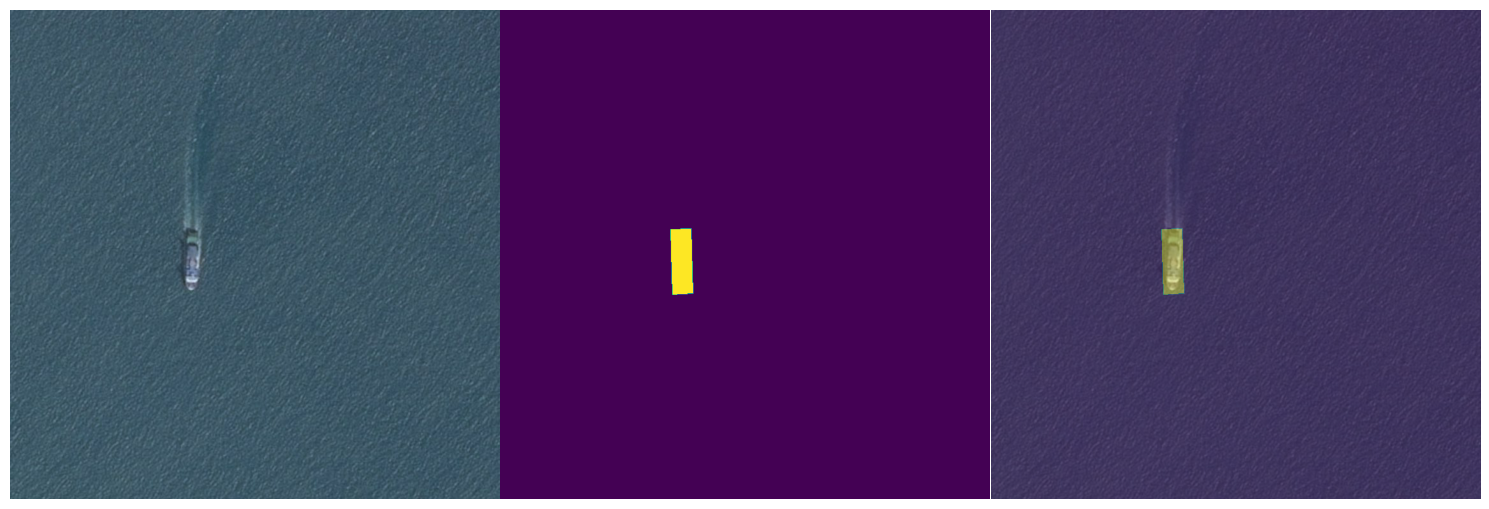

In [ ]:
img = Image.open(Config.augmented_dir + augmented_ids[0])
mask = Image.open(Config.aug_masks_dir + augmented_ids[0][:-4]+ ".png" )


fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(mask)
axarr[2].imshow(img)
axarr[2].imshow(mask, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

Next, we need to randomly discard a few images with no detected ships, since there are so many of them.

In [ ]:
zero_ships_data = ships_dfrm[ships_dfrm['AmountOfShips'] == 0]
zero_ships_data = list(zero_ships_data['ImageId'].unique()) 

for i in range(0, len(zero_ships_data), 2):
  if i < len(zero_ships_data):
    file_path = Config.data_dir + zero_ships_data[i]
    if os.path.exists(file_path):
      os.remove(file_path)
      zero_ships_data.remove(zero_ships_data[i])

In [ ]:
len(zero_ships_data)

75002

In [ ]:
len(non_zeros_ships * 2)

85112

We have slightly reduced the difference in the number of target classes.

Join new images/masks with old ones

In [ ]:
augmented_ids = [i[:-4] + "_aug.jpg" for i in non_zeros_ships]
non_zero_ids_images = non_zeros_ships + augmented_ids
non_zero_ids_masks = [i[:-4] + ".png" for i in non_zeros_ships] + [i[:-4] + ".png" for i in augmented_ids]
zero_ids_images = zero_ships_data
zero_ids_masks = ["empty" for i in range(len(zero_ids_images))]


new_data = {'ImageId': non_zero_ids_images + zero_ids_images, 'Mask': non_zero_ids_masks + zero_ids_masks}

final_dfrm = pd.DataFrame.from_dict(new_data)
final_dfrm.head(10)

,ImageId,Mask
0,000155de5.jpg,000155de5.png
1,000194a2d.jpg,000194a2d.png
2,00021ddc3.jpg,00021ddc3.png
3,0002756f7.jpg,0002756f7.png
4,00031f145.jpg,00031f145.png
5,000532683.jpg,000532683.png
6,00053c6ba.jpg,00053c6ba.png
7,0005d01c8.jpg,0005d01c8.png
8,0005d6d95.jpg,0005d6d95.png
9,0006c52e8.jpg,0006c52e8.png


Save final dataframe to csv

In [ ]:
final_dfrm.to_csv('final_dfrm.csv', index=False)

# References
[1] - https://ccshenyltw.medium.com/run-length-encode-and-decode-a33383142e6b

[2] - https://arxiv.org/pdf/1505.04597.pdf